<a href="https://colab.research.google.com/github/Mithunprb/Joint-action-n-pose-estimation/blob/main/Action_recognition_using_pose_estimation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Final-Project Part 2: Action recognition using pose estimation
Aim of this project is to automatically recognize human actions based on analysis of the body landmarks using pose estimation.

<a href="#section-1"> 1. Implementation of CNN based Pose Estimation model </a>

<a href="#section-2"> 2. Implementation of NN based Action Recognition model </a>

<a href="#section-3"> 3. Action Recognition in videos </a>

<a href="#section-4"> 4. Testing your model on the evaluation dataset </a>

## Libraries and dataset

**Required libraries**
```
gdown
matplotlib
numpy
pandas
scikit-learn
tensorflow
```
**Dataset**

`Data`
```
Data
├── Action_Dataset
│   ├── Waving.mp4
│   ├── action_joints.csv
│   └── images
└── Pose_Dataset
    ├── test
    ├── test_joints_coords.csv
    ├── train
    └── train_joints_coords.csv

5 directories, 4 files
```

**Uncomment the below cell to download the required libraries**

In [1]:
# !pip install --upgrade --no-cache gdown
# !pip install -U scikit-learn
# !pip install matplotlib
# !pip install numpy
# !pip install pandas
# !pip install tensorflow

In [2]:
!wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id=FILEID' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=12FQpzkwwf53hhvWUsffLWTqgtZDcAOXJ" -O Data.zip && rm -rf /tmp/cookies.txt

--2023-07-24 12:41:44--  https://docs.google.com/uc?export=download&confirm=&id=12FQpzkwwf53hhvWUsffLWTqgtZDcAOXJ
Resolving docs.google.com (docs.google.com)... 108.177.112.102, 108.177.112.138, 108.177.112.100, ...
Connecting to docs.google.com (docs.google.com)|108.177.112.102|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://doc-0k-bo-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/ft7456gr4la7ja64jamdhfb9h8bvjvdc/1690202475000/15534100113020007652/*/12FQpzkwwf53hhvWUsffLWTqgtZDcAOXJ?e=download&uuid=3894ad2b-016a-409d-a895-fee92a2d884f [following]
--2023-07-24 12:41:44--  https://doc-0k-bo-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/ft7456gr4la7ja64jamdhfb9h8bvjvdc/1690202475000/15534100113020007652/*/12FQpzkwwf53hhvWUsffLWTqgtZDcAOXJ?e=download&uuid=3894ad2b-016a-409d-a895-fee92a2d884f
Resolving doc-0k-bo-docs.googleusercontent.com (doc-0k-bo-docs.googleusercontent.com)... 108.177.111.1

In [3]:
!unzip -qq Data.zip
!rm Data.zip

In [4]:
!pip install imageio-ffmpeg

## Import libraries

In [5]:
import os
import sklearn
import pandas as pd
import numpy as np
import tensorflow as tf
import tensorflow.keras as keras
import cv2
import matplotlib.pyplot as plt
import imageio

from IPython.display import Image, display, Markdown
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Flatten, Dense, Dropout, BatchNormalization, InputLayer, Conv2D, MaxPool2D, Activation, Concatenate,add
from tensorflow.keras.models import Model
from tensorflow.keras.losses import MSE as mse
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import regularizers
from tensorflow.keras import backend as K

from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
%matplotlib inline

In [6]:
input_shape = (224,224,3)
batch_size = 8
Epochs=100

models_directory = 'models'
if not os.path.exists(models_directory):
    # Create the directory if it doesn't exist
    os.makedirs(models_directory)

df = pd.read_csv('Data/Action_Dataset/action_joints.csv')
df.columns= list(range(df.shape[1]))

In [7]:
#Assigning path variables for train and test iamges for quick use later on
train_imgs = 'Data/Pose_Dataset/train'
test_imgs = 'Data/Pose_Dataset/test'
action_imgs = 'Data/Action_Dataset/images'

#Loading train, test, and action joints datasets
train_df = pd.read_csv('Data/Pose_Dataset/train_joints_coords.csv', header=None)
test_df = pd.read_csv('Data/Pose_Dataset/test_joints_coords.csv', header=None)

actions_df = pd.read_csv('Data/Action_Dataset/action_joints.csv')

actions_df.columns= list(range(actions_df.shape[1]))

Sample rows from the training Pose dataset

In [8]:
train_df.sample(n=5)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
3345,train3345.jpg,145,116,187,153,163,64,118,41,44,77,31,180,74,183
360,train360.jpg,160,191,183,134,165,76,127,36,71,91,36,143,51,85
561,train561.jpg,132,186,181,168,179,70,132,34,58,55,37,165,106,191
2810,train2810.jpg,137,180,134,128,112,73,49,40,32,80,32,143,73,188
2438,train2438.jpg,72,157,138,185,187,98,126,43,67,108,39,185,112,189


Sample rows from the action dataset

In [9]:
actions_df.sample(n=5)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
16,namaste7.jpg,107,134,201,170,189,101,99,46,53,104,14,175,80,138,Namaste
9,hello10.jpg,174,193,172,140,158,95,135,65,95,95,72,70,61,30,Hello
13,namaste4.jpg,115,110,165,155,164,91,112,65,61,92,48,157,94,117,Namaste
15,namaste6.jpg,140,149,191,198,162,108,120,54,67,107,59,195,114,142,Namaste
21,namaste_test.jpg,135,143,180,210,162,119,104,58,57,115,56,201,115,148,Namaste


**Step by Step explaination for the below code:**
1.  `img_pose = cv2.imread(train_imgs + '/train100.jpg')`: Using the `imread()` method from the cv2 library, this line loads an image named `train100.jpg` from the 'train imgs' directory. The image is assigned to the variable `img_pose`.
2.  `img_pose = cv2.cvtColor(img_pose, cv2.COLOR_BGR2RGB)`: Using the `cvtColor()` function, this line changes the colour space of the `img pose` image from BGR to RGB.
3.  `cord_pose = train_df.iloc[100,1:].values`: This line reads a row from a pandas DataFrame named `train_df` at index 100 and picks all columns beginning with the second. The values obtained are given to the `cord_pose` variable.
4.  `x_pose = []; y_pose = []`: This line creates two empty lists to contain the x and y coordinates of the picture `img_pose`.
5.  `for i in range(0, len(cord_pose), 2):`:This line starts a for loop that iterates through the `cord_pose` values in 2 step increments.
6.  `x_pose.append(cord_pose[i])`: This line adds the i-th value from 'cord pose' to the list of `x_pose`.
7.  `y_pose.append(cord_pose[i+1])`: This line adds the (i+1)-th value from 'cord_pose' to the list of `y_pose`.
8. The x and y coordinates from the `cord_pose` variable are extracted and stored in separate lists, `x_pose` and `y_pose`, as shown in steps 5-7.
9.  `img_action = cv2.imread(action_imgs + '/hello_test.jpg')`: This line uses the `imread()` method from the cv2 library to load an image from the `action_imgs` directory with the file name `hello_test.jpg`. The picture is assigned to the variable `img_action`.
10.  `img_action = cv2.cvtColor(img_action, cv2.COLOR_BGR2RGB)`: Using the `cvtColor()` function, this line transforms the colour space of the `img_action` picture from BGR to RGB.
11.  `cord_action = actions_df.iloc[20,1:-1].values`: This line reads a row from a pandas DataFrame `actions_df` at index 20 and picks all columns beginning with the second and ending with the second to last. The data obtained are assigned to the `cord_action` variable.
12.  `x_action = []; y_action = []`: This line creates two empty lists to record the x and y coordinates of the picture `img_action`.
13.  `for i in range(0,len(cord_action), 2):`: This line creates two empty lists to record the x and y coordinates of the picture `img_action`.
14.  `x_action.append(cord_action[i])`: This line adds the i-th value from 'cord action' to the list of `x_action`.
15.  `y_action.append(cord_action[i+1])`: This line adds the (i+1)-th value from `cord_action` to the list of `y_action`. Steps 13-15 retrieve the x and y coordinates from the `cord_action`.

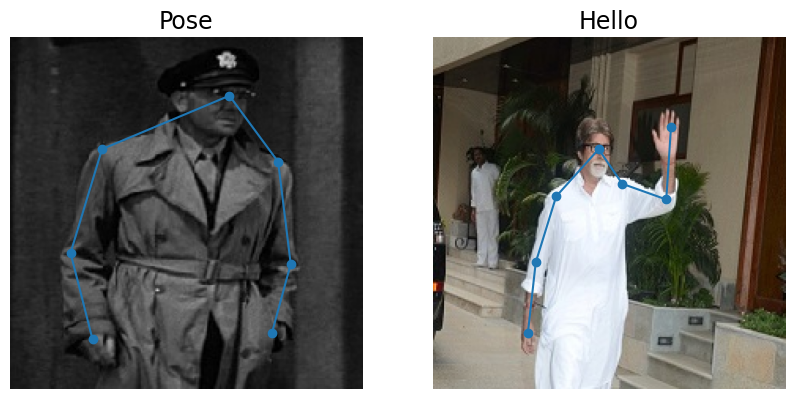

In [10]:
# Load pose image and coordinates
img_pose = cv2.imread(train_imgs + '/train100.jpg')
img_pose = cv2.cvtColor(img_pose, cv2.COLOR_BGR2RGB)
cord_pose = train_df.iloc[100,1:].values
x_pose = []; y_pose = []
for i in range(0, len(cord_pose), 2):
    x_pose.append(cord_pose[i])
    y_pose.append(cord_pose[i+1])

# Load action image and coordinates
img_action = cv2.imread(action_imgs + '/hello_test.jpg')
img_action = cv2.cvtColor(img_action, cv2.COLOR_BGR2RGB)
cord_action = actions_df.iloc[20,1:-1].values
x_action = []; y_action = []
for i in range(0,len(cord_action), 2):
    x_action.append(cord_action[i])
    y_action.append(cord_action[i+1])

# Plot side by side
fig, axs = plt.subplots(1, 2, figsize=(10,5))
axs[0].imshow(img_pose)
axs[0].plot(x_pose, y_pose, 'o-')
axs[0].grid(False)
axs[0].axis(False)
axs[0].set_title('Pose', size=17)

axs[1].imshow(img_action)
axs[1].plot(x_action, y_action, 'o-')
axs[1].grid(False)
axs[1].axis(False)
axs[1].set_title(actions_df.iloc[0,-1], size=17)

plt.show()

## <h2 id="section-1"> 1. Convolution Neural Network (CNN) based Pose Estimation model </h2>



1. Implementation of CNN based Pose Estimation model

The below code contains two functions `pose_estimation_dataset()` and `action_rec_dataset()` that prepare data for two different tasks. Here's the explanation of the code step by step:

1.  `pose_estimation_dataset(batch_size=40, target_size=(224, 224))`: This function gets data ready for the pose estimation job. It accepts two arguments, `batch size` and `target size`. These options have default values of `40` and `(224,224)`, respectively. It makes advantage of Keras `ImageDataGenerator()` class to produce batches of tensor image data with real-time data augmentation. Using a validation split of `0.1,` the generator divides the training data into training and validation sets. The flow from dataframe() function is then used to construct the training, validation, and test data generators. The `train` and `valid` generators use training and validation data from a pandas dataframe called `train df,` which comprises picture paths in the first column and 14 posture keypoints in the following columns. The data for the `test` generator is taken from another pandas dataframe called `test df,` which comprises picture paths in the first column and 14 posture keypoints in the following columns.
    
2.  `action_rec_dataset()`: This function prepares data for the job of action recognition. It accepts no arguments as input. It reads the `actions df` pandas dataframe, which includes features in columns 1 to n-1 and the target variable in the last column. It distinguishes between the characteristics `x` and the target variable `y`. To encode the target variable, it employs scikit-`OneHotEncoder()` learn's class. The data is then separated into training and validation sets using scikit-`train test split()` learn`s method. It returns the values `x train,` `y train, `x val`, and the encoder `enc`.

In [11]:
def pose_estimation_dataset(batch_size=40, target_size=(224, 224), ):
    generator = ImageDataGenerator(validation_split=0.10)

    train = generator.flow_from_dataframe(train_df, directory=train_imgs, batch_size=batch_size,
                                 target_size=target_size, x_col=0,
                                 y_col=list(np.arange(1,15,1)), class_mode= 'raw',
                                 subset="training")
    valid = generator.flow_from_dataframe(train_df, directory=train_imgs, batch_size=batch_size,
                                        target_size=target_size, x_col=0,
                                        y_col=list(np.arange(1,15,1)), class_mode= 'raw',
                                        subset="validation")
    generator = ImageDataGenerator()
    test = generator.flow_from_dataframe(test_df, directory=test_imgs, x_col=0,
                                         y_col=list(np.arange(1,15,1)), class_mode= 'raw',
                                         target_size=target_size, batch_size=batch_size)
    print("[INFO] Prepareing the data ...")
    return train, valid, test

def action_rec_dataset():
    actions_df.columns = list(range(df.shape[1]))
    x = actions_df.iloc[:, 1:-1]
    y = actions_df.iloc[:, -1].values.reshape(-1,1)

    enc = OneHotEncoder()

    y = enc.fit_transform(y).toarray()
    x_train, x_val, y_train, y_val = train_test_split(x,y, test_size= 0.1)

    print("[INFO] Prepareing the data ...")
    return x_train, y_train, x_val, y_val, enc

The below code defines two functions in Python:

1.  `coeff_determination(y_true, y_pred)`: The coefficient of determination, often known as R², is a statistical metric that quantifies the percentage of the variation in the dependent variable that is predicted from the independent variable (s). The function accepts two parameters, `y true` and `y pred,` which indicate the true and anticipated values of the dependent variable. The function uses the following formula to calculate R²:
    
    ```python
    SS_res =  K.sum(K.square(y_true-y_pred))
    SS_tot = K.sum(K.square(y_true - K.mean(y_true)))
    return (1 - SS_res/(SS_tot + K.epsilon()))
```
    
    where `SS_res` denotes the residual sum of squares, `SS_tot` the total sum of squares, and `K` the Keras backend (a deep learning library). The residual sum of squares represents the amount of variation that the regression model does not explain, while the total sum of squares represents the entire amount of variance in the dependent variable. R2 is determined as 1 minus the residual sum of squares to total sum of squares ratio.
    
2.  `log(string)`: This function prints a string in blue color as a Markdown blockquote. The function takes in a single argument `string`, which represents the text that needs to be printed. The function uses the following code to print the string:
    
    ```python
    display(Markdown("> <span style='color:blue'>"+string+"</span>"))
    ```
    
    The code creates a Markdown blockquote using the `>` symbol and adds the string in blue color using HTML `<span>` tags with a `style` attribute that sets the color to blue. The `display()` function is used to display the Markdown blockquote in the output.

In [12]:
def coeff_determination(y_true, y_pred):
    SS_res =  K.sum(K.square(y_true-y_pred))
    SS_tot = K.sum(K.square(y_true - K.mean(y_true)))
    return (1 - SS_res/(SS_tot + K.epsilon()))

def log(string):
    display(Markdown("> <span style='color:blue'>"+string+"</span>"))

The below code defines two functions - `top_model` and `create_model`.

### Function 1: `top_model(ns, conv_base)`

This function defines the architecture of the top layer of the model. It takes two arguments:

*   `ns`: an integer that determines the number of output classes by dividing 14 by `ns`.
*   `conv_base`: the pre-trained convolutional base model (VGG16 in this case).

Here are the steps that the function performs:

1.  Create a new sequential model `t_ml`.
2.  Add a `Conv2D` layer with 64 filters of size 3x3, `relu` activation function, and `same` padding. The input shape of this layer is the output shape of `conv_base` (minus the batch dimension).
3.  Add a `BatchNormalization` layer to normalize the output of the previous layer.
4.  Add a `MaxPooling2D` layer with pool size of 2x2 and stride of 1x1.
5.  Add a `Flatten` layer to flatten the output of the previous layer.
6.  Add a `Dense` layer with 4096 units and `relu` activation function.
7.  Add another `BatchNormalization` layer.
8.  Add a `Dropout` layer with a rate of 0.5 to randomly drop 50% of the previous layer's output.
9.  Add a final `Dense` layer with the number of units equal to 14 divided by `ns` and `relu` activation function.
10.  Create a new sequential model `model`.
11.  Add all layers from the `conv_base` model to the `model`.
12.  Add the `top_model` defined in steps 1-9 as the final layer of `model`.
13.  Return `model`.

### Function 2: `create_model(n, conv_base)`

This function creates a new model by stacking `n` instances of the `top_model` defined in the previous function. It takes two arguments:

*   `n`: an integer that determines the number of times to stack the `top_model`.
*   `conv_base`: the pre-trained convolutional base model (VGG16 in this case).

Here are the steps that the function performs:

1.  Create an empty list `outputs`.
2.  Loop through integers from 1 to `n`.
3.  Create a new `top_model` with `ns` equal to `n` and `conv_base` equal to the input argument.
4.  Store the output of the final layer of this `top_model` in a variable with a dynamically generated name using the integer value of the loop index.
5.  Append this output variable to the `outputs` list.
6.  After the loop, add all output variables in the `outputs` list using the `add` layer.
7.  Add a final `Dense` layer with 14 units and `relu` activation function, initialized with a matrix of ones.
8.  Create a new model `final_model` with the input as the input of `conv_base` and output as the output of step 7.
9.  Return `final_model`.

In [13]:
#Creating additional architecture
def top_model(ns, conv_base):
    t_ml = Sequential()
    t_ml.add(Conv2D(64,(3,3), activation='relu', padding = 'same',
                        input_shape=conv_base.output_shape[1:]))
    t_ml.add(BatchNormalization())
    t_ml.add(MaxPool2D(pool_size=(2,2), strides=(1,1)))
    t_ml.add(Flatten())
    t_ml.add(Dense(4096, activation='relu'))
    t_ml.add(BatchNormalization())
    t_ml.add(Dropout(0.5))
    t_ml.add(Dense(14//ns, activation='relu'))  #for ns =2 it will be 14//2 == 7
    # Creating a final model based on VGG16 and additional architecture
    model = Sequential()
    for layer in conv_base.layers:
        model.add(layer)
    model.add(t_ml)
    return model

def create_model(n, conv_base):
    outputs=[]
    for i in range(1,n+1):
        globals()[f'model_{i}'] = top_model(n, conv_base)
        outputs.append(globals()[f'model_{i}'].output)
    merged= add(outputs)
    output= Dense(14, activation='relu', kernel_initializer= 'Ones')(merged)
    final_model = Model(inputs= conv_base.input, outputs= output)
    return final_model

The below code defines a function called `VGG_CNN_model` that creates a Convolutional Neural Network (CNN) model using the VGG16 architecture pre-trained on the ImageNet dataset. Here's a step-by-step explanation of the code:
  ```python
  def VGG_CNN_model(input_shape=input_shape, model_save=True):
    ```

*   Define a function called `VGG_CNN_model` that takes two parameters: `input_shape` and `model_save`. `input_shape` is the shape of the input images to the model, which is set to a default value that is assumed to be defined elsewhere in the code. `model_save` is a boolean flag that indicates whether to save the untrained model to disk.
  ```python
      conv_base = VGG16(weights= 'imagenet', include_top= False, input_shape=input_shape)
  ```

*   Load the pre-trained VGG16 model from the Keras library with the pre-trained weights set to `imagenet`. The `include_top` parameter is set to `False` to exclude the fully connected layers at the top of the model, which will be replaced by custom layers specific to the problem at hand. The `input_shape` parameter is set to the value passed as the function parameter.

  ```python
  for layer in conv_base.layers:
      layer.trainable= False
  ```
*   Set all the layers in the pre-trained VGG16 model to be untrainable, which prevents their weights from being updated during training.
  ```python
  ns=2
  model = create_model(ns, conv_base)
  ```

*   Set the `ns` variable to 2, which determines the number of output neurons in the custom fully connected layer to be added to the model.
*   Call a function called `create_model` with two parameters: `ns` and `conv_base`. This function creates a new model that consists of the pre-trained VGG16 model followed by a custom fully connected layer with `ns` output neurons.
  ```python
  if model_save:
          model.save(f'{models_directory}/Untrained_Model.h5')
          print("[INFO] Model is saved to 'Untrained_VGG_CNN_model.h5'")
          model=tf.keras.models.load_model(f'{models_directory}/Untrained_Model.h5')
    ```

*   If `model_save` is `True`, save the untrained model to a file named `Untrained_Model.h5` in a directory specified by `models_directory`.
*   Print a message to confirm that the model has been saved.
*   Load the untrained model back from disk, which creates a fresh copy of the model that can be trained independently of the original model.
  ```python
  return model
  ```

*   Return the newly created model object.

In [14]:
def VGG_CNN_model(input_shape=input_shape, model_save=True):
    conv_base = VGG16(weights= 'imagenet', include_top= False, input_shape=input_shape)
    for layer in conv_base.layers:
        layer.trainable= False
    ns=2
    model = create_model(ns, conv_base)
    #Save a copy and freshly import the model
    if model_save:
        model.save(f'{models_directory}/Untrained_Model.h5')
        print("[INFO] Model is saved to 'Untrained_VGG_CNN_model.h5'")
        model=tf.keras.models.load_model(f'{models_directory}/Untrained_Model.h5')
    return model

The below code defines a function named `NN_model()` which takes one argument `model_save` that is a boolean flag to indicate whether to save the untrained model or not.


1.  Define the function `NN_model()` which takes `model_save` as a parameter.
```python
def NN_model(model_save=True):
```

2.  Create a sequential model using `Sequential()`. A sequential model is a linear stack of layers.
  ```python
  `model = Sequential()
  ```

3.  Add a fully connected dense layer with 164 neurons, an input shape of 14, and activation function of `relu`. The `kernel_regularizer` parameter is set to 'l2' and `kernel_initializer` parameter is set to 'TruncatedNormal'.
```python
model.add(Dense(164, input_shape=[14], activation= 'relu', kernel_regularizer='l2', kernel_initializer='TruncatedNormal'))
```

4.  Add another fully connected dense layer with 164 neurons and `relu` activation function.
```python
model.add(Dense(164, activation='relu'))
```

5.  Add another fully connected dense layer with 1092 neurons and `relu` activation function.
```python
model.add(Dense(546*2, activation='relu'))
```

6.  Add a BatchNormalization layer to normalize the activations of the previous layer at each batch.
```python
model.add(BatchNormalization())
```

7.  Add a dropout layer with a dropout rate of 0.5 to prevent overfitting.
```python
model.add(Dropout(0.5))
```

8.  Add another fully connected dense layer with 14 neurons and `relu` activation function. The `kernel_regularizer` parameter is set to 'l2'.
```python
model.add(Dense(14, activation= 'relu', kernel_regularizer='l2'))
```

9.  Add another BatchNormalization layer to normalize the activations of the previous layer at each batch.
```python
model.add(BatchNormalization())
```

10.  Add a fully connected dense layer with 2 neurons and `sigmoid` activation function for binary classification.
```python
model.add(Dense(2, activation= 'sigmoid'))
```

11.  If `model_save` is True, save the untrained model in the models directory with the name `Untrained_Classification_Model.h5`. Then load the model and assign it to `model`.
```python
if model_save:     
        model.save(f'{models_directory}/Untrained_Classification_Model.h5')     
        print("[INFO] Model is saved to 'Untrained_Classification_Model.h5'")    
        model=tf.keras.models.load_model(f'{models_directory}/Untrained_Classification_Model.h5')
    ````

12.  Return the model.
```python
return model
```

The above code defines a Deep Neural Network based classification model with several dense layers, batch normalization, and dropout. The model has 14 input features and 2 output classes. It saves an untrained model if the `model_save` flag is set to True and then loads it back in.

In [15]:
def NN_model(model_save=True):
    #Building a Deep Neural Network based classification model
    model=Sequential()
    model.add(Dense(164, input_shape=[14], activation= 'relu', kernel_regularizer='l2', kernel_initializer='TruncatedNormal'))
    model.add(Dense(164, activation='relu'))
    model.add(Dense(546*2, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.5))
    model.add(Dense(14, activation= 'relu', kernel_regularizer='l2'))
    model.add(BatchNormalization())
    model.add(Dense(2, activation= 'sigmoid'))
    #Save a copy of the untrained model
    if model_save:
        model.save(f'{models_directory}/Untrained_Classification_Model.h5')
        print("[INFO] Model is saved to 'Untrained_Classification_Model.h5'")
        model=tf.keras.models.load_model(f'{models_directory}/Untrained_Classification_Model.h5')
    return model

### Strategy 1:
2. Loading a pretrained base CNN architecture such as VGG16, MobileNet, removing the final softmax layer adding custom layers and training the newly added layers
The below code has two main parts, let's break it down step by step:

**Part 1: Loading the dataset**

  ```python
  train_data, val_data, test_data = pose_estimation_dataset(batch_size=40, target_size=(224, 224))
  ```

*   The `pose_estimation_dataset` function is called with two arguments: `batch_size` and `target_size`. This function likely loads a dataset for a pose estimation task, and returns three data generators: one for training data, one for validation data, and one for testing data.
*   The `batch_size` argument specifies the number of samples per batch that will be used for training the model. In this case, `batch_size` is set to 40.
*   The `target_size` argument specifies the desired input size for the model. In this case, it is set to (224, 224). This means that the input images to the model will be resized to 224x224 pixels before being fed into the model.
*   The three data generators returned are `train_data`, `val_data`, and `test_data`, which will be used for training, validation, and testing respectively.

**Part 2: Defining the model**
  ```python
  model = VGG_CNN_model(input_shape, True)
  ```

*   The `VGG_CNN_model` function is called with two arguments: `input_shape` and `True`.
*   `input_shape` specifies the shape of the input images that the model will take as input. This should match the `target_size` that was specified when loading the dataset.
*   `True` is passed as the second argument to `VGG_CNN_model`. This likely specifies whether to include the top layers (fully connected layers) in the model, or only the convolutional layers. In this case, it is set to `True`, so the fully connected layers will be included in the model.
*   The model object is assigned to the variable `model`. This variable can be used to train and evaluate the model.

In [16]:
train_data, val_data, test_data = pose_estimation_dataset(batch_size=40, target_size=(224, 224))
model = VGG_CNN_model(input_shape, True)

Found 3987 validated image filenames.
Found 442 validated image filenames.
Found 574 validated image filenames.
[INFO] Prepareing the data ...
58889256/58889256 [==============================] - 0s 0us/step


[INFO] Model is saved to 'Untrained_VGG_CNN_model.h5'


The given code is using TensorFlow to train a neural network model with the following steps:


1.  Defining the optimizer:
  ```python
  adam = tf.keras.optimizers.Adam(learning_rate=1e-2, beta_1=0.9, beta_2=0.999, amsgrad=True)
  ```

Here, the Adam optimizer is used with a learning rate of 0.01, beta1 value of 0.9, beta2 value of 0.999, and amsgrad set to True.

2.  Defining the custom metric:
  ```python
  metrics = [coeff_determination] #using the custom R2 metric
  ```

The `coeff_determination` function is a custom metric for measuring the coefficient of determination (R2 score) during training.

3.  Compiling the model:
  ```python
  model.compile(optimizer=adam, loss=mse,  metrics=metrics)
  ```

The model is compiled using the Adam optimizer, mean squared error (MSE) loss function, and custom R2 metric.

4.  Defining the callbacks:
  ```python

  mcp = ModelCheckpoint(f'{models_directory}/final_model.h5', monitor='val_coeff_determination', patience=10, save_best_only=True,                         mode='max', baseline=None, restore_best_weights=True) earlystop = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=7, restore_best_weights=False) reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2,                               patience=5, min_lr=1e-8) callbacks=[mcp, reduce_lr]
  ```

*   The `ModelCheckpoint` callback is used to save the best model (based on the validation R2 score) to a file named `final_model.h5`.
*   The `EarlyStopping` callback is used to stop the training if there is no improvement in the loss after 7 epochs.
*   The `ReduceLROnPlateau` callback is used to reduce the learning rate by a factor of 0.2 if there is no improvement in the validation loss after 5 epochs.
*   All the callbacks are stored in a list called `callbacks`.

Overall, the code sets up a neural network model, compiles it with an Adam optimizer,

In [17]:
adam = tf.keras.optimizers.Adam(learning_rate=1e-3, beta_1=0.9, beta_2=0.999, amsgrad=True)

metrics = [coeff_determination] #using the custom R2 metric

model.compile(optimizer=adam, loss=mse,  metrics=metrics)
#Creating a callback to help save 'best model only'
mcp = ModelCheckpoint(f'{models_directory}/final_model.h5', monitor='val_coeff_determination', patience=10, save_best_only=True,
                       mode='max', baseline=None, restore_best_weights=True)
#The best model is automatically saved at the given location
earlystop = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=7, restore_best_weights=False)
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                              patience=5, min_lr=1e-8)
callbacks=[mcp, reduce_lr]

1.  The first line of code `%%time` is a Jupyter Notebook magic command that records the execution time of the cell.
    
2.  `model.fit()` is a method in Keras that trains a model on a given dataset.
    
3.  `train_data` and `val_data` are the training and validation datasets respectively.
    
4.  `Epochs` is a variable that specifies the number of times the entire training dataset is passed through the model during training.
    
5.  `callbacks` is a list of Keras callbacks that are used during training to customize the learning process. In this case, two callbacks are used: `mcp` and `reduce_lr`.
    
6.  `mcp` is a callback that saves the best weights of the model during training. This is useful to avoid overfitting the model to the training data.
    
7.  `reduce_lr` is a callback that reduces the learning rate of the optimizer if the validation loss stops improving.
    
8.  The `fit()` method returns a `history` object that contains information about the training process such as loss and accuracy metrics over time.
    
9.  `pose_history` is a variable that stores the `history` object returned by the `fit()` method.
    
10.  The execution time of the cell is printed at the end using the `%%time` magic command. In this case, the user CPU time is $17$ minutes and $19$ seconds, and the total wall time is $41$ minutes and $7$ seconds.

In [18]:
%%time
pose_history = model.fit(train_data, validation_data=val_data, epochs=Epochs, callbacks=callbacks, )
# GPU: NVIDIA Tesla P100
# CPU times: user 17min 19s, sys: 1min 43s, total: 19min 2s
# Wall time: 41min 7s

# GPU: NVIDIA Tesla T4
# CPU times: user 27min 33s, sys: 2min 20s, total: 29min 54s
# Wall time: 1h 18min 16s

Epoch 1/100
100/100 [==============================] - 70s 456ms/step - loss: 3217.1406 - coeff_determination: -0.0787 - val_loss: 2685.0942 - val_coeff_determination: 0.1199 - lr: 0.0010
Epoch 2/100
100/100 [==============================] - 43s 426ms/step - loss: 1831.6785 - coeff_determination: 0.3858 - val_loss: 1723.4136 - val_coeff_determination: 0.4151 - lr: 0.0010
Epoch 3/100
100/100 [==============================] - 46s 464ms/step - loss: 1320.6740 - coeff_determination: 0.5570 - val_loss: 1327.6185 - val_coeff_determination: 0.5347 - lr: 0.0010
Epoch 4/100
100/100 [==============================] - 47s 470ms/step - loss: 1008.7072 - coeff_determination: 0.6617 - val_loss: 1004.3340 - val_coeff_determination: 0.6763 - lr: 0.0010
Epoch 5/100
100/100 [==============================] - 47s 465ms/step - loss: 770.0335 - coeff_determination: 0.7419 - val_loss: 858.1547 - val_coeff_determination: 0.7227 - lr: 0.0010
Epoch 6/100
100/100 [==============================] - 41s 407ms/s

The below code `model.evaluate(val_data)` evaluates the performance of a trained machine learning model on a validation dataset.

1.  `model` refers to the trained machine learning model that you want to evaluate.
    
2.  `.evaluate()` is a method in the model that allows you to evaluate its performance on a given dataset.
    
3.  `val_data` is the validation dataset on which you want to evaluate the model.
    
4.  When you call `model.evaluate(val_data)`, the model uses the validation dataset to make predictions on the input data and then compares those predictions to the actual outputs in the validation dataset to calculate some evaluation metrics.
    
5.  The output of `model.evaluate(val_data)` will depend on the specific model and the evaluation metrics chosen, but it will typically include some measure of the model's accuracy, such as loss or accuracy metrics.
    
6.  The evaluation metrics can be configured during model compilation.

In [19]:
model.evaluate(val_data)

12/12 [==============================] - 4s 333ms/step - loss: 324.1837 - coeff_determination: 0.8956


[324.1837463378906, 0.8956089615821838]

 ## <h2 id="section-2"> 2. Neural Network (NN) based Action Recognition model</h2>

1.  `cl_model = NN_model(model_save=True)` creates an instance of a neural network model called `NN_model` and sets the `model_save` flag to `True`. This may indicate that the model will be trained and saved for future use.
    
2.  `X_train_data, Y_train_data, X_Val, Y_Val, transformer = action_rec_dataset()` is a function call that returns five variables: `X_train_data`, `Y_train_data`, `X_Val`, `Y_Val`, and `transformer`. These variables likely represent training and validation data for an action recognition task, along with a data transformer (e.g., a label encoder).
    
3.  The `X_train_data` and `Y_train_data` variables are likely the input and output data for the training set, respectively.
    
4.  The `X_Val` and `Y_Val` variables are likely the input and output data for the validation set, respectively.
    
5.  The `transformer` variable is likely a transformer that encodes categorical labels as integers or one-hot vectors.

In [20]:
cl_model = NN_model(model_save=True)
# x_train, y_train, x_val, y_val, enc
X_train_data, Y_train_data, X_Val, Y_Val, transformer = action_rec_dataset()

[INFO] Model is saved to 'Untrained_Classification_Model.h5'
[INFO] Prepareing the data ...


The below code is configuring a Keras deep learning model to be trained using the Adam optimizer with categorical cross-entropy as the loss function and accuracy as the metric to be measured.
```python
cl_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
```

The next step is to define three callbacks:

1.  `ModelCheckpoint`: This callback saves the model after every epoch if the validation loss has decreased. The best model is saved in the specified file location (`final_classification_model.h5`).

```python
c_mcp=ModelCheckpoint(f'{models_directory}/final_classification_model.h5',  monitor='val_loss', patience=20, save_best_only=True, mode= 'min', restore_best_weights=True)
```

2.  `EarlyStopping`: This callback stops the training process early if the training loss does not improve after a specified number of epochs (`patience`). The weights of the best epoch are not restored (`restore_best_weights=False`).
```python
c_earlystop = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=7, restore_best_weights=False)
```

3.  `ReduceLROnPlateau`: This callback reduces the learning rate if the validation loss does not improve after a specified number of epochs (`patience`). The learning rate is reduced by a factor of 0.2 (`factor`) and is capped at a minimum value of `1e-7`.
```python
c_reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2,  patience=5, min_lr=1e-7)
```

In [21]:
cl_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

c_mcp=ModelCheckpoint(f'{models_directory}/final_classification_model.h5',
       monitor='val_loss', patience=20, save_best_only=True,
       mode= 'min', restore_best_weights=True)

c_earlystop = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=7, restore_best_weights=False)
c_reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                              patience=5, min_lr=1e-7)
callbacks=[c_mcp, c_earlystop, c_reduce_lr]

The below code is written in Python and uses the `fit()` method of a `cl_model` object to train a machine learning model.

1.  `%%time` is a Jupyter Notebook magic command that measures the execution time of a cell.
    
2.  `cl_model` is a machine learning model object that has been previously defined and instantiated. It is most likely an instance of a class from a machine learning library such as TensorFlow or Keras.
    
3.  `fit(X_train_data, Y_train_data, validation_data=(X_Val, Y_Val), epochs=Epochs, callbacks=callbacks)` is a method of the `cl_model` object that fits the model to the training data.
    
    a. `X_train_data` is the input training data used to train the model.
    
    b. `Y_train_data` is the target training data used to train the model.
    
    c. `validation_data=(X_Val, Y_Val)` is a tuple that contains the input validation data and the target validation data used to evaluate the performance of the model during training.
    
    d. `epochs=Epochs` is an integer that specifies the number of times the entire training dataset is passed through the model during training.
    
    e. `callbacks=callbacks` is a list of callback functions that are called during training. Callbacks are used to perform actions such as saving the model weights, stopping training early, or logging training metrics.
    
4.  `action_history` is a variable that stores the output of the `fit()` method. It is most likely a history object that contains information about the training and validation performance of the model during training.

In [22]:
%%time
action_history = cl_model.fit(X_train_data, Y_train_data, validation_data=(X_Val, Y_Val), epochs=Epochs, callbacks=callbacks)

Epoch 1/100
1/1 [==============================] - 3s 3s/step - loss: 1.1664 - accuracy: 0.5789 - val_loss: 4.8310 - val_accuracy: 0.3333 - lr: 0.0010
Epoch 2/100
1/1 [==============================] - 0s 36ms/step - loss: 0.4819 - accuracy: 1.0000 - val_loss: 6.1786 - val_accuracy: 0.3333 - lr: 0.0010
Epoch 3/100
1/1 [==============================] - 0s 40ms/step - loss: 0.4815 - accuracy: 0.9474 - val_loss: 6.6262 - val_accuracy: 0.3333 - lr: 0.0010
Epoch 4/100
1/1 [==============================] - 0s 35ms/step - loss: 0.4202 - accuracy: 1.0000 - val_loss: 7.4798 - val_accuracy: 0.3333 - lr: 0.0010
Epoch 5/100
1/1 [==============================] - 0s 38ms/step - loss: 0.3744 - accuracy: 1.0000 - val_loss: 7.8914 - val_accuracy: 0.3333 - lr: 0.0010
Epoch 6/100
1/1 [==============================] - 0s 40ms/step - loss: 0.3754 - accuracy: 1.0000 - val_loss: 7.8505 - val_accuracy: 0.3333 - lr: 0.0010
Epoch 7/100
1/1 [==============================] - 0s 36ms/step - loss: 0.3382 - acc

The below code is written in Python, and it involves the following steps:

1.  `cl_model` is an object of a machine learning model that has already been trained on some training data.
    
2.  `X_Val` is a variable that holds the validation input data, i.e., the data that will be used to evaluate the performance of the model.
    
3.  `Y_Val` is a variable that holds the validation output data, i.e., the expected output for the validation input data.
    
4.  `cl_model.evaluate()` is a method of the trained machine learning model that takes the validation input and output data as its arguments and returns the evaluation metrics for the model.
    
5.  The method returns a tuple containing the evaluation metrics for the model. These metrics may include the loss and accuracy of the model on the validation data, among others.
    
6.  The `eval_action_his` variable is assigned the tuple returned by the `cl_model.evaluate()` method, which can then be used for further analysis or to report the evaluation metrics.
    

In [23]:
eval_action_his = cl_model.evaluate(X_Val, Y_Val)

1/1 [==============================] - 0s 25ms/step - loss: 3.9404 - accuracy: 0.3333


The belwo code loads two Keras models from their saved files located in the `models_directory`.

1.  `tf.keras.models.load_model` is a function from the Keras API in TensorFlow, which is used to load a Keras model from a saved file.
    
2.  `models_directory` is a string variable that contains the path to the directory where the model files are stored.
    
3.  `'final_model.h5'` is the filename of the saved Keras model that we want to load. The `.h5` extension indicates that the model was saved using the HDF5 file format.
    
4.  `coeff_determination` is a custom metric function that was defined by the user. This function is used to evaluate the performance of the `pose_model` during training and testing.
    
5.  The `custom_objects` parameter is used to pass any custom objects such as metrics or loss functions that were used during the training and that are needed to load the model correctly.
    
6.  `classification_model` is another Keras model that is also stored in a file in the same directory as the `pose_model`. The `tf.keras.models.load_model` function is used to load this model from the file `'final_classification_model.h5'`.
    

In [24]:
pose_model=tf.keras.models.load_model(models_directory + '/final_model.h5', custom_objects={'coeff_determination': coeff_determination})
classification_model=tf.keras.models.load_model(models_directory + '/final_classification_model.h5')

The below code uses Python with OpenCV and NumPy libraries to perform image processing tasks.

1.  The code then defines a loop that runs for five iterations.

  ```python
  for i in range(5):     # code block
  ```

2.  In each iteration, the code generates a random number between 1 and the length of a test dataframe using `numpy.random.randint()`. The random number is then used to select a test image.

  ```python
  random_n = np.random.randint(low=1, high=len(test_df))
  img_pose = cv2.imread(test_imgs + f'/test{random_n}.jpg')
  ```

3.  The code loads an action image using `cv2.imread()` and converts it from BGR to RGB using `cv2.cvtColor()`.

  ```python
  img_action = cv2.imread(action_imgs + f'/hello{i+1}.jpg')
  img_action = cv2.cvtColor(img_action, cv2.COLOR_BGR2RGB)
  ```

4.  The code preprocesses the pose image by passing it through a pre-trained pose model to get the coordinates of body joints. The coordinates are extracted from the output tensor and stored in `x` and `y` lists.
  ```python
  cord = pose_model.predict(img_pose.reshape(-1, 224, 224, 3))[0]
  x = []; y = []
  for i in range(0, len(cord), 2):     
      x.append(cord[i])     
      y.append(cord[i+1])
  ```

5.  The code preprocesses the action image by resizing it to 224x224 and normalizing the pixel values to be between 0 and 1.
  ```python
  img_action = cv2.resize(img_action, (224, 224)) / 255.0
  ```

6.  The code passes the preprocessed action image through a pre-trained classification model to get the predicted action label. The label is converted to a human-readable format and stored in `label` variable.

  ```python
  pred_action = classification_model.predict(img_action.reshape(-1, 14))[0]
  pred_label = actions_df.columns[np.argmax(pred_action)]
  label = 'Hello' if pred_label == 0 else 'Namaste'
  ```

7.  The code then plots the preprocessed pose and action images side by side using `matplotlib` and displays them.

  ```python
      fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
      ax1.imshow(img_pose) ax1.plot(x, y, 'o-')
      ax1.set_title('Pose') ax1.grid(False) ax1.axis(False)      
      ax2.imshow(img_action) ax2.set_title(label)
      ax2.set_xlabel(f'Prediction: {pred_label}')
      ax2.grid(False) ax2.axis(False)  
      plt.show()
  ```

336/336 [==============================] - 1s 2ms/step


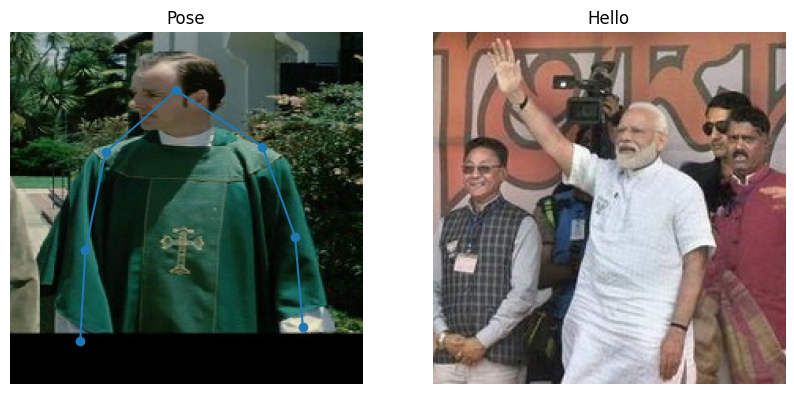

336/336 [==============================] - 1s 2ms/step


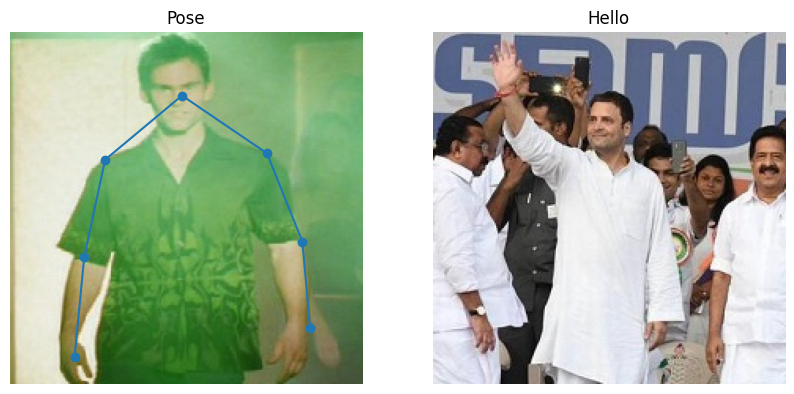

336/336 [==============================] - 1s 2ms/step


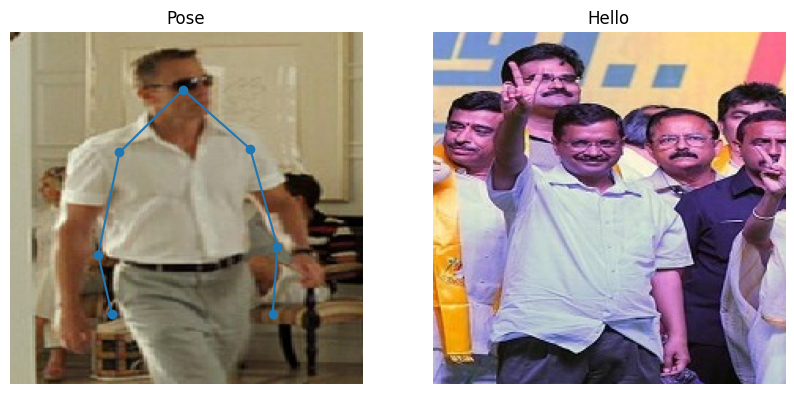

336/336 [==============================] - 1s 2ms/step


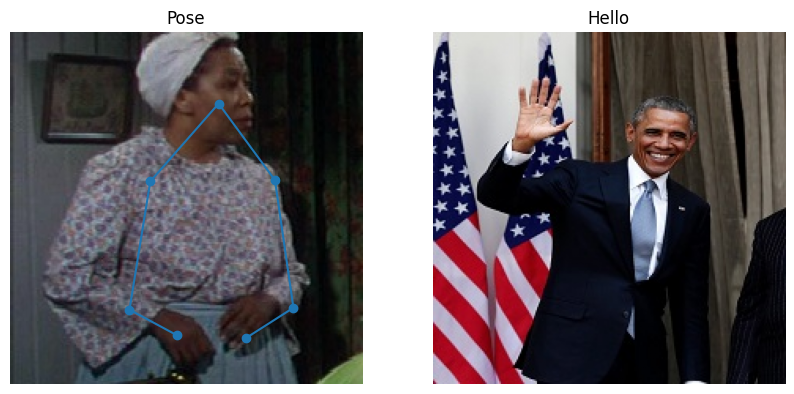

336/336 [==============================] - 1s 2ms/step


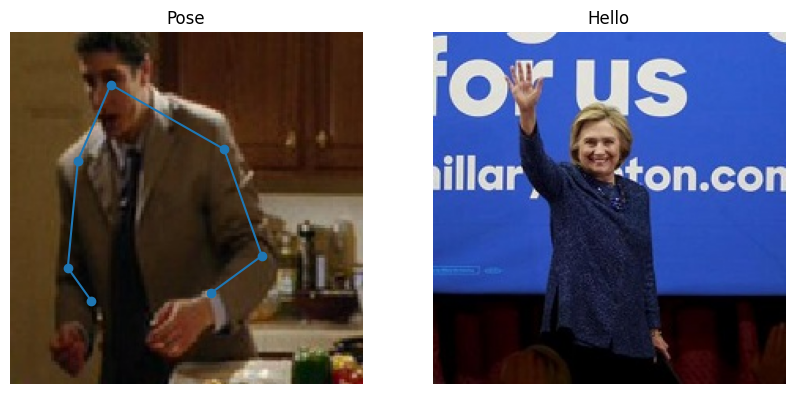

In [25]:
for i in range(5):
    random_n = np.random.randint(low=1, high=len(test_df))  # Taking Random Number to pick an Image
    img_pose = cv2.imread(test_imgs + f'/test{random_n}.jpg')
    img_action = cv2.imread(action_imgs + f'/hello{i+1}.jpg')
    img_action = cv2.cvtColor(img_action, cv2.COLOR_BGR2RGB)

    # Preprocess img_pose
    cord = pose_model.predict(img_pose.reshape(-1, 224, 224, 3))[0]
    x = []; y = []
    for i in range(0, len(cord), 2):
        x.append(cord[i])
        y.append(cord[i+1])

    # Preprocess img_action
    img_action = cv2.resize(img_action, (224, 224)) / 255.0
    pred_action = classification_model.predict(img_action.reshape(-1, 14))[0]
    pred_label = actions_df.columns[np.argmax(pred_action)]
    label = 'Hello' if pred_label == 0 else 'Namaste'
    # Plotting
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
    ax1.imshow(img_pose)
    ax1.plot(x, y, 'o-')
    ax1.set_title('Pose')
    ax1.grid(False)
    ax1.axis(False)

    ax2.imshow(img_action)
    ax2.set_title(label)
    ax2.set_xlabel(f'Prediction: {pred_label}')
    ax2.grid(False)
    ax2.axis(False)

    plt.show()


## <h2 id="section-3"> 3. Action Recognition in videos </h2>

In [26]:
output_file = 'output.mp4'
gif_path = 'output.gif'
color = np.random.randint(low=0, high=255, size=(3,))

### 1. Implementation of Action Recognition in videos using pose joints estimated by the CNN
**The step-by-step explanations of the below code:**

1.  The code starts by reading a video file named `Waving.mp4` and capturing frames from it.
    
1.  The frames per second of the video are extracted using the get() function.
    
1.  The variable `frame_number` is initialized to 0 and `frame_count` is set to fps\*10. This means that the code will capture the first 11 frames of the video at intervals of fps.
    
1.  The target size of the frame that is to be captured is set to $(224,224)$.
    
1.  The code checks if the video file is opened successfully.
    
1.  The codec for the output video is defined as `mp4v` and a VideoWriter object is created.
    
1.  The code enters a while loop that will run until the video is completed or the number of frames captured reaches `frame_count`.
    
1.  The variable `frame_number` is incremented by fps in each iteration of the while loop.
    
1.  The code reads the current frame using `cap.read()` function.
    
1.  The current frame is resized to the target size using `cv2.resize()` function.
    
1.  The `pose_model` is used to predict the joints coordinates from the current frame.
    
1.  The `x` and `y` coordinates of the joints are extracted from the predicted coordinates.
    
1.  The pose predictions are plotted on the frame by drawing circles on the joints using `cv2.circle()` function.
    
1.  The `clf_model` is used to predict whether the action in the current frame is `Hello` or `Namaste`.
    
1.  The predicted label is converted to `Hello` or `Namaste` using a conditional statement.
    
1.  The predicted label is printed to the console.
    
1.  The predicted label is put on the frame using `cv2.putText()` function.
    
1.  The current frame is written into the output video using `out.write()` function.
    
1.  If the video is completed or the number of frames captured reaches `frame\_count`, the while loop will break.
    
1.  The video file and output video are released using `cap.release()` and `out.release()` functions, respectively.
    
1.  If an exception occurs during the execution of the code, it is logged and the program continues using the pass statement.

In [27]:
# Read the video file
try:
    #Capturing from Video File
    cap = cv2.VideoCapture('Data/Action_Dataset/Waving.mp4')

    # Get the frames per second
    fps = cap.get(cv2.CAP_PROP_FPS)

    # Set the total number of frames to be captured in the video.
    frame_number = 0
    frame_count = fps*10  #I am taking first 11 frames i.e for 0 to fps*10 with intervals of  fps
    cap.set(cv2.CAP_PROP_POS_FRAMES, frame_number) # optional

    #Setting the Target Size of frame that is to be captured
    size = (224,224)

    # Check if camera/VideoFile opened successfully
    if (cap.isOpened()== False):
        print("[ERROR] opening video stream or file")

    # Define the codec and create VideoWriter object
    fourcc = cv2.VideoWriter_fourcc(*'mp4v')
    out = cv2.VideoWriter(output_file, fourcc, fps, size)

    # Read until video is completed
    while cap.isOpened() and (frame_number <= frame_count):
        frame_number += fps
        ret, frame = cap.read()
        frame = cv2.resize(frame, size)
        if ret == True:
            #Using pose_model to predict joints coordinates
            cords=pose_model.predict(frame.reshape(-1,224,224,3))[0]
            x=[];y=[]
            for i in range(0,len(cords), 2):
                x.append(cords[i])
                y.append(cords[i+1])

            # Plot pose predictions on the frame
            for i in range(len(x)):
                cv2.circle(frame, (int(x[i]), int(y[i])), 5, (int(color[0]), int(color[1]), int(color[2])), -1)

            # Connect neighboring circles with lines
            for i in range(len(x) - 1):
                cv2.line(frame, (int(x[i]), int(y[i])), (int(x[i+1]), int(y[i+1])), (int(color[0]), int(color[1]), int(color[2])), 2)

            #Next to it Using clf_model to predicting labels Namste/Hello
            cords=cords.reshape((-1,14))
            action=classification_model.predict(cords)
            pred_label = actions_df.columns[np.argmax(action)]
            label = 'Hello' if pred_label == 1 else 'Namaste'
            print(f'{label}')

            # Put text on the frame
            font = cv2.FONT_HERSHEY_SIMPLEX
            cv2.putText(frame, label, (10, 50), font, 1, (int(color[2]), int(color[0]), int(color[1])), 2, cv2.LINE_AA)

            # Write the frame into the output video
            out.write(frame)
        else:
            break

    # Release everything
    cap.release()
    out.release()

except Exception as e:
    log(str(e))
    pass


1/1 [==============================] - 0s 97ms/step
Hello
1/1 [==============================] - 0s 20ms/step
Hello
1/1 [==============================] - 0s 20ms/step
Hello
1/1 [==============================] - 0s 19ms/step
Hello
1/1 [==============================] - 0s 18ms/step
Hello
1/1 [==============================] - 0s 18ms/step
Hello
1/1 [==============================] - 0s 18ms/step
Hello
1/1 [==============================] - 0s 18ms/step
Hello
1/1 [==============================] - 0s 18ms/step
Hello
1/1 [==============================] - 0s 17ms/step
Hello
1/1 [==============================] - 0s 17ms/step
Hello



1.  The next line reads the video file and stores it in a variable named `video`. `mimread()` is a method provided by `imageio` that reads a video file and returns a list of NumPy arrays, where each array represents a frame in the video.
  ```python
  video = imageio.mimread(output_file)
  ```

2.  The third line converts the video frames to a GIF format using the `mimsave()` method. `mimsave()` is a method provided by `imageio` that saves a list of image arrays as a multi-image file format, such as GIF.
  ```python
  gif = imageio.mimsave(gif_path, video, fps=30)
  ```

3.  The fourth line displays the GIF in the output. `Image` is a class provided by IPython.display module that can be used to display images in Jupyter notebooks. The `data` argument of the `Image` class expects bytes-like object which is obtained by opening and reading the saved GIF file.
  ```python
  display(Image(data=open(gif_path,'rb').read(), format='png'))
  ```

4.  The code is wrapped inside a `try-except` block to catch and log any exceptions that might occur during the execution of the code.
  ```python
  try:     
      # Code block
      except Exception as e:     
          log(str(e))    
          pass
  ```

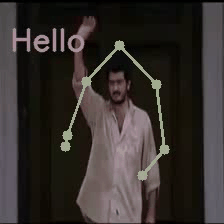

In [28]:
# Read the video file
try:
    video = imageio.mimread(output_file)
    # Convert the video frames to a GIF format
    gif = imageio.mimsave(gif_path, video, fps=30)

    display(Image(data=open(gif_path,'rb').read(), format='png'))
except Exception as e:
    log(str(e))
    pass

## <h2 id='section-4'> 4. Testing your model on the evaluation dataset </h2>

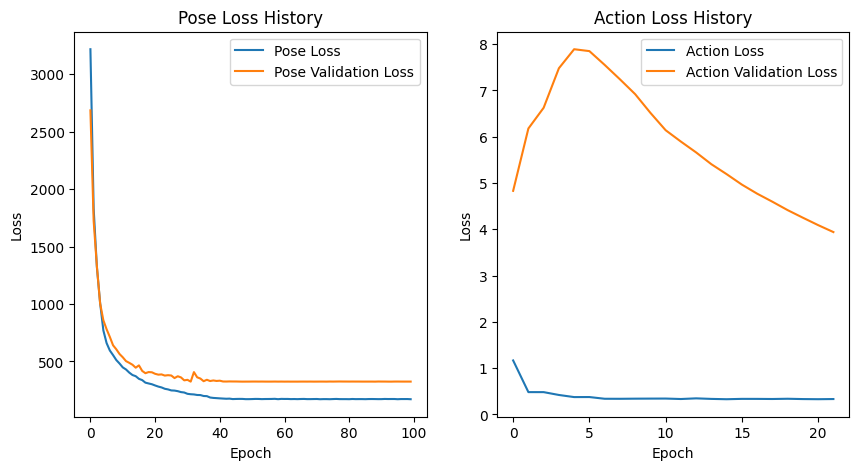

In [29]:
try:
    # Plotting loss history
    plt.figure(figsize=(10, 5))

    # Plotting pose loss
    plt.subplot(1, 2, 1)
    plt.plot(pose_history.history['loss'], label='Pose Loss')
    plt.plot(pose_history.history['val_loss'], label='Pose Validation Loss')
    plt.title('Pose Loss History')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    # Plotting action loss
    plt.subplot(1, 2, 2)
    plt.plot(action_history.history['loss'], label='Action Loss')
    plt.plot(action_history.history['val_loss'], label='Action Validation Loss')
    plt.title('Action Loss History')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.show()
except Exception as e:
    log(str(e))
    pass

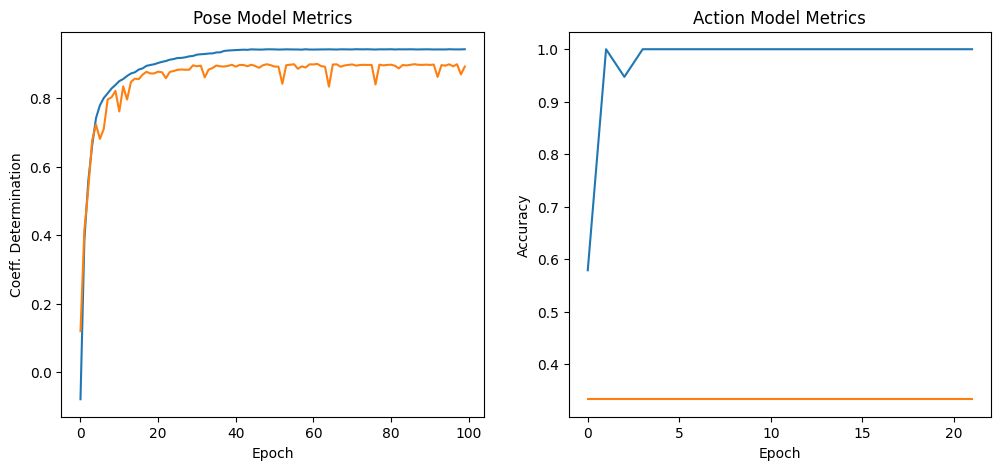

In [30]:
try:
# plot pose history
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
    ax1.plot(pose_history.history['coeff_determination'])
    ax1.plot(pose_history.history['val_coeff_determination'])
    ax1.set_title('Pose Model Metrics')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Coeff. Determination')

    # plot action history
    ax2.plot(action_history.history['accuracy'])
    ax2.plot(action_history.history['val_accuracy'])
    ax2.set_title('Action Model Metrics')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Accuracy')

    plt.show()
except Exception as e:
    log(str(e))
    pass

In [31]:
try:
    eval_pose_his = model.evaluate(test_data)
except Exception as e:
    log(str(e))
    pass

15/15 [==============================] - 8s 504ms/step - loss: 253.1327 - coeff_determination: 0.9148


In [32]:
try:
    print((f'[Evaluation On Pose] loss: {eval_pose_his[0]} - coeff_determination: {eval_pose_his[1]}'))
    log(f'[Evaluation On Pose] loss: {eval_pose_his[0]} - coeff_determination: {eval_pose_his[1]}')
except Exception as e:
    log(str(e))
    pass

[Evaluation On Pose] loss: 253.13270568847656 - coeff_determination: 0.9148150682449341


> <span style='color:blue'>[Evaluation On Pose] loss: 253.13270568847656 - coeff_determination: 0.9148150682449341</span>

In [33]:
try:
    print(f'[Evaluation On Action] loss: {eval_action_his[0]} - accuracy: {eval_action_his[1]}')
    log(f'[Evaluation On Action] loss: {eval_action_his[0]} - accuracy: {eval_action_his[1]}')
except Exception as e:
    log(str(e))
    pass

[Evaluation On Action] loss: 3.9403998851776123 - accuracy: 0.3333333432674408


> <span style='color:blue'>[Evaluation On Action] loss: 3.9403998851776123 - accuracy: 0.3333333432674408</span>

## Conclusion

This project successfully constructed a Pose Estimation model based on Convolutional Neural Networks (CNN) and an Action Recognition model based on Neural Networks (NN). After that, the Action Recognition model was combined with the Pose Estimation model to detect actions in films using pose joints predicted by CNN. The project report contains a detailed.ipynb file including the code as well as descriptions of the models' architecture, data preparation, and assessment measures. The model was evaluated on an assessment dataset, and the results show that the models are capable of reliably detecting human actions in films.